ra_h:dec_d 18.6157944196343:38.7854452961918
['/data/lvm/sci/agcam/east/20221116/lvm.sci.agcam.east_00000093.fits', '/data/lvm/sci/agcam/center/20221116/lvm.sci.agcam.center_00000061.fits', '/data/lvm/sci/agcam/west/20221116/lvm.sci.agcam.west_00000093.fits']


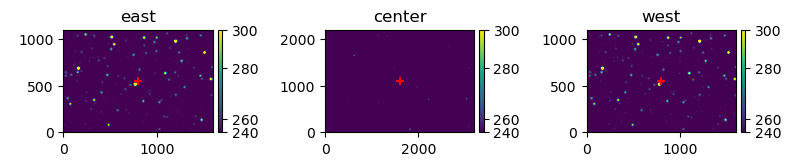

In [1]:
%matplotlib widget
#%matplotlib inline 

import asyncio

from cluplus.proxy import invoke

from lvmtipo.actors import lvm
from lvmagp.images import Image
from plotimg import plot_images

import numpy as np

import matplotlib.pyplot as plt
import sys
from matplotlib.colors import LogNorm

await lvm.sci.foc.start()
await lvm.sci.foc.status()

await lvm.sci.agc.start()

await lvm.sci.km.start()
await lvm.sci.km.status()

await lvm.sci.pwi.start()

ra_h, dec_d = (await lvm.sci.pwi.status()).flatten().unpack("ra_j2000_hours", "dec_j2000_degs")
print(f"ra_h:dec_d {ra_h}:{dec_d}")

await lvm.sci.km.slewStart(ra_h, dec_d)

exptime = 5
rc = await lvm.sci.agc.expose(exptime)
filenames = rc.flatten().unpack("*.filename") 
print(filenames)

images = [Image.from_file(f) for f in filenames]
plot_images(images)
#print(images[0].header)



In [2]:
touple_list = [(i.data, i.header) for i in images]
#print(touple_list)

In [3]:
import astropy.coordinates
import astropy.time
import astropy.units as u

from lvmtipo.site import Site
from lvmtipo.siderostat import Siderostat
from lvmtipo.fiber import Fiber
from lvmtipo.target import Target
from lvmtipo.ambient import Ambient
from lvmtipo.kmirror import Kmirror

from astropy.utils import iers
iers.conf.auto_download = False

site = Site(name = "MPIA")

azang = 180.0
medSign = -1

sid = Siderostat(azang=azang, medSign=medSign)
ambi = Ambient()

homeOffset = 135
homeIsWest = False

kmirror = Kmirror(home_is_west=homeIsWest, home_offset=homeOffset)

hdu = images[0].header
target = Target(astropy.coordinates.SkyCoord(ra=hdu['RA'], dec=hdu['DEC'], unit=(u.hourangle, u.deg)))
print(f"{hdu['RA']=} {hdu['DEC']=} {hdu['KMIRSTEP']=}  {hdu['KMIRDROT']=}   {hdu['DATE-OBS']=}")


touple_list = []
for img in images:
  touple_list.append((img.data, sid.to_wcs(site, target, None, ambi, img.header['KMIRSTEP'], 
                                            img.header['CAMNAME'], False, False, kmirror, pixsize=img.header['PIXSIZE'],
                                            bin=1,wd=img.header['NAXIS1'],hd=img.header['NAXIS2'])))

# touple_list

hdu['RA']=279.2369162945145 hdu['DEC']=38.7854452961918 hdu['KMIRSTEP']=2240559.0  hdu['KMIRDROT']=-10.52450001244756   hdu['DATE-OBS']='2022-11-16T19:10:16.430'


Set OBSGEO-Y to   630879.729 from OBSGEO-[LBH].
Set OBSGEO-Z to  4819800.536 from OBSGEO-[LBH]'. [astropy.wcs.wcs]


In [4]:
import reproject
from reproject.mosaicking import find_optimal_celestial_wcs

wcs_out, shape_out= reproject.mosaicking.find_optimal_celestial_wcs(touple_list)

reprojected_arrays = []
footprints = []
for index,touple in enumerate(touple_list):
    print(index)

    reprojected_array,current_footprint = reproject.reproject_interp(touple, wcs_out,shape_out=shape_out)
    reprojected_arrays.append(reprojected_array)
    footprints.append(current_footprint)

0
1
2


In [5]:
stack = np.array(reprojected_arrays)
stack_combined = np.nanmedian(stack,axis=0)
footprints_sum = np.sum(np.array(footprints),axis=0)

[WARNING]: All-NaN slice encountered (RuntimeWarning)


Text(0.5, 1.0, 'Reprojected Guide Image')

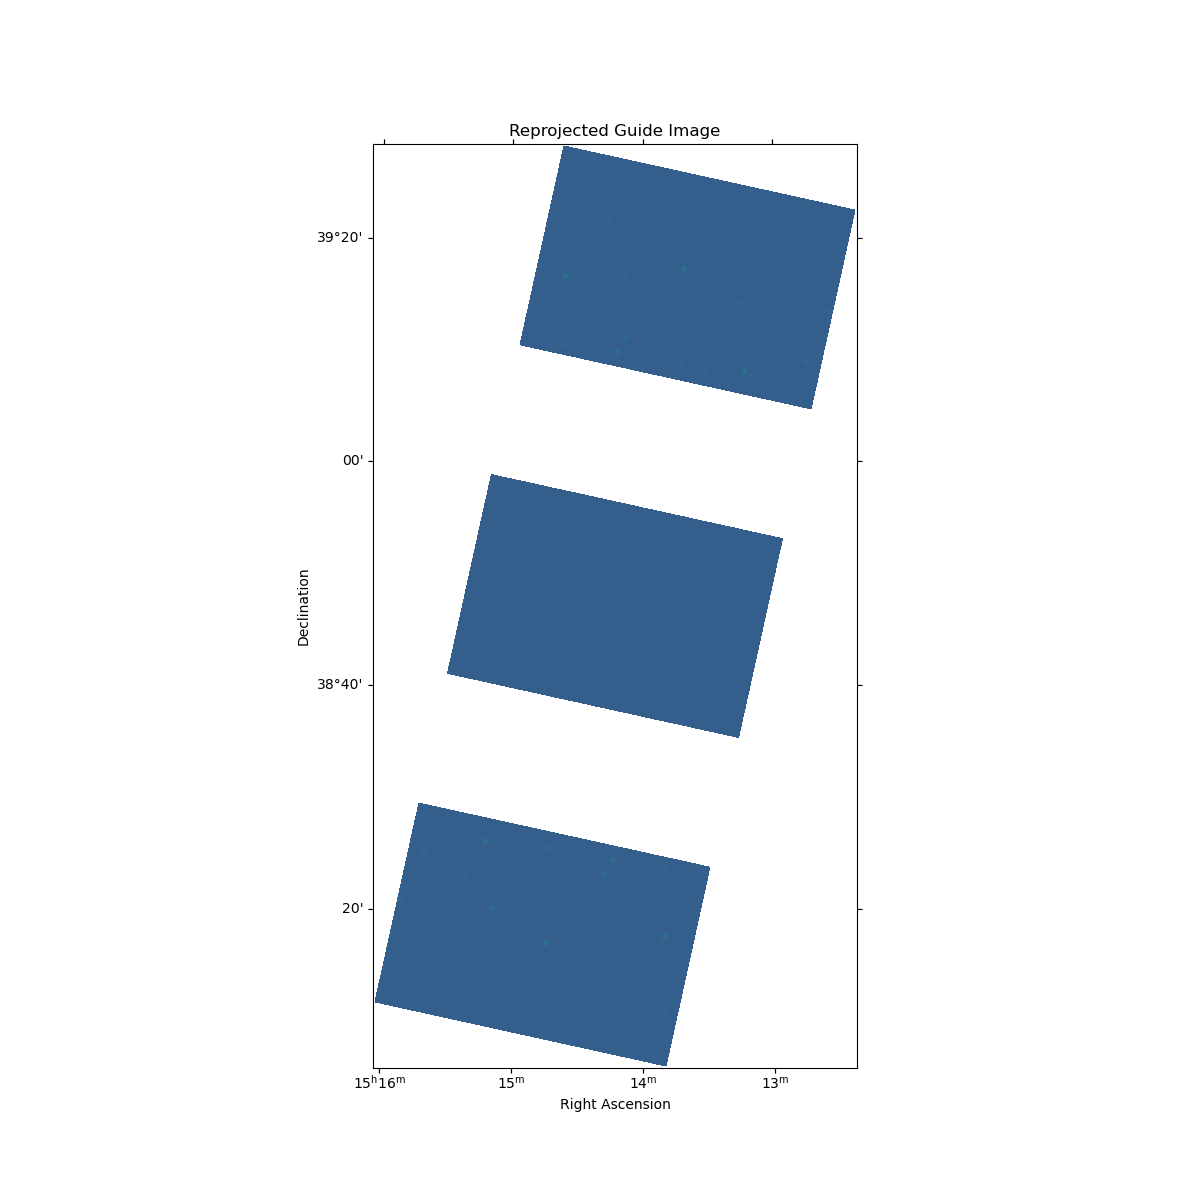

In [6]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(projection=wcs_out)
ax1.imshow(stack_combined, norm=LogNorm(vmin=50, vmax=10000))
#ax1.plot(gaia_pixel_repro[0],gaia_pixel_repro[1],"wo",markerfacecolor="None",ms=20,alpha=0.8)
ax1.coords['ra'].set_axislabel('Right Ascension')
ax1.coords['dec'].set_axislabel('Declination')
ax1.set_title('Reprojected Guide Image')